In [1]:
%load_ext autoreload
%autoreload 2

# Global Fairness Verification example

*Based on Calzavara et al. Explainable Global Fairness Veriﬁcation of Tree-Based Classiﬁers" (2022).*

This example focuses on fairness that expresses (a lack of) causal discrimination. It is a global fairness (or verification of global robustness) task which means that is does not rely on the choice of a specific test set, but (implicitly) ranges over all possible instances.

## Preliminaries

In [2]:
import time
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

## German dataset

We will use the [German Credit Data](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data) benchmark dataset.

### Load the data

In [3]:
X_df, y_df = datasets.fetch_openml(data_id=31, return_X_y=True, as_frame=True)

Make the target numerical

In [4]:
y = (y_df=='good').astype(int)

In [5]:
ordinal_feature_indexes = [0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19]
ord_enc = OrdinalEncoder(categories=[
    ['<0', '0<=X<200', '>=200', 'no checking'], # 0: checking_status
    ['no credits/all paid', 'all paid', 'existing paid', 'delayed previously', 'critical/other existing credit'], # 2: credit_history
    ['domestic appliance', 'furniture/equipment', 'radio/tv', 'repairs',
         'new car', 'used car', 'business', 'education', 'retraining', 'other'], # 3: purpose, likely better as one-hot
    ['<100', '100<=X<500', '500<=X<1000', '>=1000', 'no known savings'], # 5: saving_status
    ['<1', '1<=X<4', '4<=X<7', '>=7', 'unemployed'], # 6: employment
    ['female div/dep/mar', 'male div/sep', 'male mar/wid', 'male single'], # 8: personal_status
    ['none', 'co applicant', 'guarantor'], # 9: other parties
    ['no known property', 'car', 'real estate', 'life insurance'], # 11: property_magnitude
    ['none', 'stores', 'bank'], # 13: other_payment_plans
    ['for free', 'rent', 'own'], # 14: housing
    ['unemp/unskilled non res', 'unskilled resident', 'skilled', 'high qualif/self emp/mgmt'], # 16: job
    ['none', 'yes'], # 18: own_telephone
    ['no', 'yes'], # 19: foreign_worker
])
ordinals = ord_enc.fit_transform(X_df.iloc[:, ordinal_feature_indexes])
columns = []
for k in range(X_df.shape[1]):
    if k in ordinal_feature_indexes:
        u = [u for u, v in enumerate(ordinal_feature_indexes) if v == k][0]
        columns.append(ordinals[:, u])
    else:
        columns.append(X_df.iloc[:, k].values)
X_df = pd.DataFrame(np.array(columns).T, columns=X_df.columns)

In [6]:
X = X_df.to_numpy()

We will focus on sex as a relevant parameter, thus will split up column 9 (index 8) 'personal_status'.

In [7]:
# Simplify the personal_status feature to just female/male for simplicity
print(ord_enc.categories[5])
featmap = [1, 0, 0, 0] # 1 => female, 0 => male
X[:, 8] = [featmap[int(val)] for val in X[:, 8]]

['female div/dep/mar', 'male div/sep', 'male mar/wid', 'male single']


Introduce bias: we can optionally introduce bias to make the effect easier to see.

In [8]:
introduce_bias = 100
if introduce_bias > 0:
    X[0:introduce_bias, :] = X[0, :]
    half_idx = int(introduce_bias/2)
    X[:half_idx, 8] = 0
    y[:half_idx] = 1
    X[half_idx:introduce_bias, 8] = 1
    y[half_idx:introduce_bias] = 0

Use train and test set

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=73)

### Train the classifier

In [10]:
import veritas
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

The original paper uses 12 trees of depth 6.

In [11]:
n_estimators = 12 # 50
params = {
    "n_estimators": n_estimators,
    "eval_metric": "error",
    "random_state": 73,
    
    "tree_method": "hist",
    "max_depth": 6,
    "learning_rate": 0.5,
    "colsample_bynode": 0.75,
    "subsample": 1.0,
}

model = xgb.XGBClassifier(**params)

t = time.time()
model.fit(X, y)
print(f"XGB trained in {time.time()-t:.2f} seconds")

XGB trained in 0.02 seconds


In [12]:
ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)
acc_train = accuracy_score(ytrain, ytrain_pred)
acc_test = accuracy_score(ytest, ytest_pred)

print(f"Train acc: {acc_train*100:.1f}%, test acc: {acc_test*100:.1f}%")

Train acc: 96.0%, test acc: 98.5%


### Global fairness

The `personal_status` (converted to female/male) is considered sensitive. Who are the subset of people whose credit risk prediction does not change by ﬂipping their sex. This maps to a query where we want to contrast two instances.

Start with loading the trained model, veritas figures out automatically it is a XGB model.

In [13]:
at = veritas.get_addtree(model, silent=True)

For two instances X0 and X1, allowing only feature 9 (index 8) 'personal_status' to be different between the two instances, what is the maximum output difference at(X1)-at(X0)?
The values that occur are 'male single', 'female div/dep/mar', 'male div/sep' and 'male mar/wid'. Thus only the 2nd (index 1) is female.

In [14]:
def constrast_two_examples(at, columns, nonfixed_columns):
    """Create an `veritas.AddTree` that contrast two instances.
    
    The new AddTree outputs difference between the original AddTree's outputs
    for instances 0 and 1.

    at: The original veritas.AddTree tree ensemble model
    columns: array with column names
    nonfixed_columns: columns that are allowed to change between the two instances
    """
    feat_map = veritas.FeatMap(columns)
    for column in columns:
        if column not in nonfixed_cols:
            index_for_instance0 = feat_map.get_index(column, 0)
            index_for_instance1 = feat_map.get_index(column, 1)
            feat_map.use_same_id_for(index_for_instance0, index_for_instance1)

    at_for_instance1 = feat_map.transform(at, 1)
    at_contrast = at.concat_negated(at_for_instance1)

    print("  Feature IDs used by instance 0\n   and instance 1 respectively:")
    print("-"*(25+4+4))
    for column in columns:
        mark = "*" if column in nonfixed_columns else ""
        feat_id_instance0 = feat_map.get_feat_id(column, 0)
        feat_id_instance1 = feat_map.get_feat_id(column, 1)
        print(f"{column:25s} {feat_id_instance0:3d} {feat_id_instance1:3d}", mark)
    
    return at_contrast, feat_map

nonfixed_cols = {'personal_status'}
at_contrast, feat_map = constrast_two_examples(at, X_df.columns, nonfixed_cols)

  Feature IDs used by instance 0
   and instance 1 respectively:
---------------------------------
checking_status             0   0 
duration                    1   1 
credit_history              2   2 
purpose                     3   3 
credit_amount               4   4 
savings_status              5   5 
employment                  6   6 
installment_commitment      7   7 
personal_status             8  28 *
other_parties               9   9 
residence_since            10  10 
property_magnitude         11  11 
age                        12  12 
other_payment_plans        13  13 
housing                    14  14 
existing_credits           15  15 
job                        16  16 
num_dependents             17  17 
own_telephone              18  18 
foreign_worker             19  19 


In [15]:
# We optimize the output of the contrasting ensemble `at_contrast`
config = veritas.Config(veritas.HeuristicType.MAX_OUTPUT)

# We are interested in cases where the output of instance 0 is greater
# than the output of instance 1, i.e., their output difference is greater
# than 0.0.
config.ignore_state_when_worse_than = 0.0

# Veritas uses an approximate search.
# We modify the parameters of the approximate search to more aggressively work
# on lowering the upper bound instead of also trying to find suboptimal solutions.
config.focal_eps = 0.95
config.max_focal_size = 100

# Obtain the search object from the search configuration
# We can optionally constrain certain feature values (e.g., look only for
# cases where instance 0 describes a male person)
#prune_box = {feat_map.get_feat_id("personal_status", 0): veritas.Interval(0, 0.5)}
prune_box = {}
search = config.get_search(at_contrast, prune_box)

bounds = []
num_search_steps_per_iteration = 100
stop_reason = veritas.StopReason.NONE

with tqdm() as pbar:
    #while search.num_solutions() < 10:  # search until we find 10 solutions
    while stop_reason != stop_reason.OPTIMAL:  # search until it is certain that the best solution is optimal
        stop_reason = search.steps(num_search_steps_per_iteration)
        bound_lh = search.current_bounds()
        bounds.append((bound_lh.atleast, bound_lh.top_of_open))
        pbar.update(1)
        pbar.set_description(f"lower {bound_lh.atleast:.3f}, "
                             f"upper {bound_lh.top_of_open:.3f}, "
                             f"#sols {search.num_solutions():<4d}")

lower 6.951, upper 6.916, #sols 1012: : 2016it [00:05, 363.39it/s]


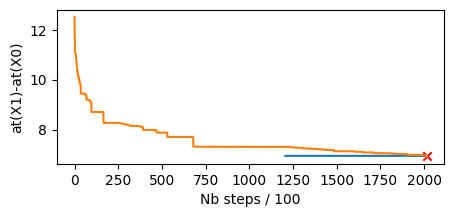

In [16]:
lo, hi = zip(*bounds)
i = list(range(len(bounds)))
sol = search.get_solution(0) # best solution so far
plt.figure(figsize=(5,2))
plt.plot(i, lo)
plt.plot(i, hi);
plt.xlabel(f'Nb steps / {num_search_steps_per_iteration}')
plt.ylabel('at(X1)-at(X0)')
plt.scatter(len(bounds)-1, sol.output, marker="x", color="red");

We found multiple solutions.

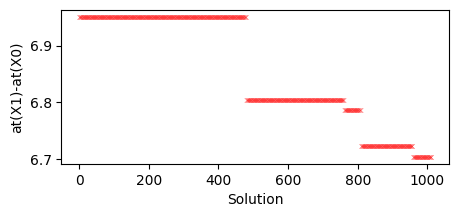

In [17]:
plt.figure(figsize=(5,2))
sol_i = list(range(search.num_solutions()))
sol_values = [search.get_solution(i).output for i in sol_i]
plt.xlabel('Solution')
plt.ylabel('at(X1)-at(X0)')
plt.scatter(sol_i, sol_values, s=10, marker="x", lw=0.1, color="red");

We will focus on that solution where the model is most sure that the target should be different even though only sex is different.

In [18]:
print("Maximum difference between instance0 and instance1")
if search.num_solutions() > 0:
    sol = search.get_solution(0)  # best solution so far
    print("- current best solution:", sol.output, "->",
          "optimal" if search.is_optimal() else "suboptimal", "solution")
    print("- feature value ranges:")
    for feat_id, ival in sol.box().items():
        column = feat_map.get_name(feat_id)
        mark = "*" if column in nonfixed_cols else " "
        print(f"    {mark}{feat_id:>3d} {column:>25s}", ival)

Maximum difference between instance0 and instance1
- current best solution: 6.950628373759333 -> optimal solution
- feature value ranges:
       0           checking_status Interval(<1)
       1                  duration Interval(>=28)
       2            credit_history Interval(>=4)
       3                   purpose Interval(5,6)
       4             credit_amount Interval(1047,1107)
       5            savings_status Interval(>=4)
       6                employment Interval(>=4)
       7    installment_commitment Interval(<3)
    *  8           personal_status Interval(<1)
       9             other_parties Interval(<1)
      10           residence_since Interval(>=3)
      11        property_magnitude Interval(<3)
      12                       age Interval(>=67)
      13       other_payment_plans Interval(<1)
      14                   housing Interval(>=2)
      15          existing_credits Interval(>=2)
      16                       job Interval(<2)
      17            num_depe

In [19]:
def contrasting_examples_from_solutions(feat_map, sol, columns):
    nb_features = len(feat_map)
    two_examples = np.zeros((2, nb_features))
    box = sol.box()

    for instance in (0, 1):
        for column in columns:
            feat_id = feat_map.get_feat_id(column, instance)
            feat_id_untrasformed = feat_map.get_feat_id(column, 0)
            if feat_id in box:
                interval = box[feat_id]
                if interval.lo_is_unbound():
                    assert not interval.hi_is_unbound()
                    value = interval.hi - 1e-4  # not inclusive
                else:
                    value = interval.lo
                if feat_id_untrasformed in ordinal_feature_indexes:  # ordinal feature
                    value = np.floor(value)
                two_examples[instance, feat_id_untrasformed] = value

    return pd.DataFrame(two_examples, columns=columns, index=["instance 0", "instance 1"])

two_examples = contrasting_examples_from_solutions(feat_map, sol, X_df.columns)
predictions = pd.Series(model.predict(two_examples), index=["instance 0", "instance 1"])

In [20]:
two_examples.T.round(1)

,instance 0,instance 1
checking_status,0.0,0.0
duration,28.0,28.0
credit_history,4.0,4.0
purpose,5.0,5.0
credit_amount,1047.0,1047.0
savings_status,4.0,4.0
employment,4.0,4.0
installment_commitment,3.0,3.0
personal_status,0.0,1.0
other_parties,0.0,0.0


The only value that differs between these two exampes are `personal_status`.

When we compute the predictions for these two examples, we obtain different classes, even though these two examples only differ in `personal_status`.

In [21]:
predictions = model.predict(two_examples)
probabilities = model.predict_proba(two_examples)[:, 1]       # probability of class 1
raw_scores = model.predict(two_examples, output_margin=True)  # pre-sigmoid raw scores

outputs = pd.DataFrame(np.vstack((
                            predictions,
                            100*probabilities,
                            raw_scores)).T,
                       columns=["class", "probability%", "raw_score"],
                       index=["instance 0", "instance 1"])
outputs.T.round(1)

,instance 0,instance 1
class,1.0,0.0
probability%,97.8,8.0
raw_score,3.8,-2.4
